# Prepare Spatial Objects

## Load environment

In [1]:
import os

import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq

In [2]:
import plotnine as p9

In [3]:
import bbknn

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
data_dir = "/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/visium/GSE182939/"

## Load & Prepare objects

In [5]:
slides = os.listdir(data_dir)

In [6]:
adatas = dict()

In [7]:
for slide in slides:
    adata = sq.read.visium(path=data_dir + slide + '/outs')
    adata.var_names_make_unique()
    
    sample = slide.split("_")[0]
    adata.obs["sample"] = sample
    adata.obs.index = sample + "-" + adata.obs.index
    
    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=400)
    sc.pp.filter_genes(adata, min_cells=5)
    
    # Additional QC
    adata.var['mt'] = adata.var_names.str.startswith('mt-') 
    adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
    adata.var['hb'] = adata.var_names.str.contains(("^Hb[^(P)]"))

    # Calculate qc
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
    
    adatas[slide] = adata

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Additional Filtering

In [8]:
qc_metrics = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb']

In [9]:
qc_thresholds = pd.read_csv('/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/visium/' + 'qc_thresholds.csv', index_col=0)

In [10]:
qc_thresholds = qc_thresholds.transpose().to_dict()

In [11]:
qc_thresholds['f2dps_158_processed']

{'gene_thr_max': 6000.0,
 'gene_thr_min': 400.0,
 'total_thr': 25000.0,
 'mt_thr': 23.0,
 'ribo_thr': 23.0,
 'hb_thr': 0.4}

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.


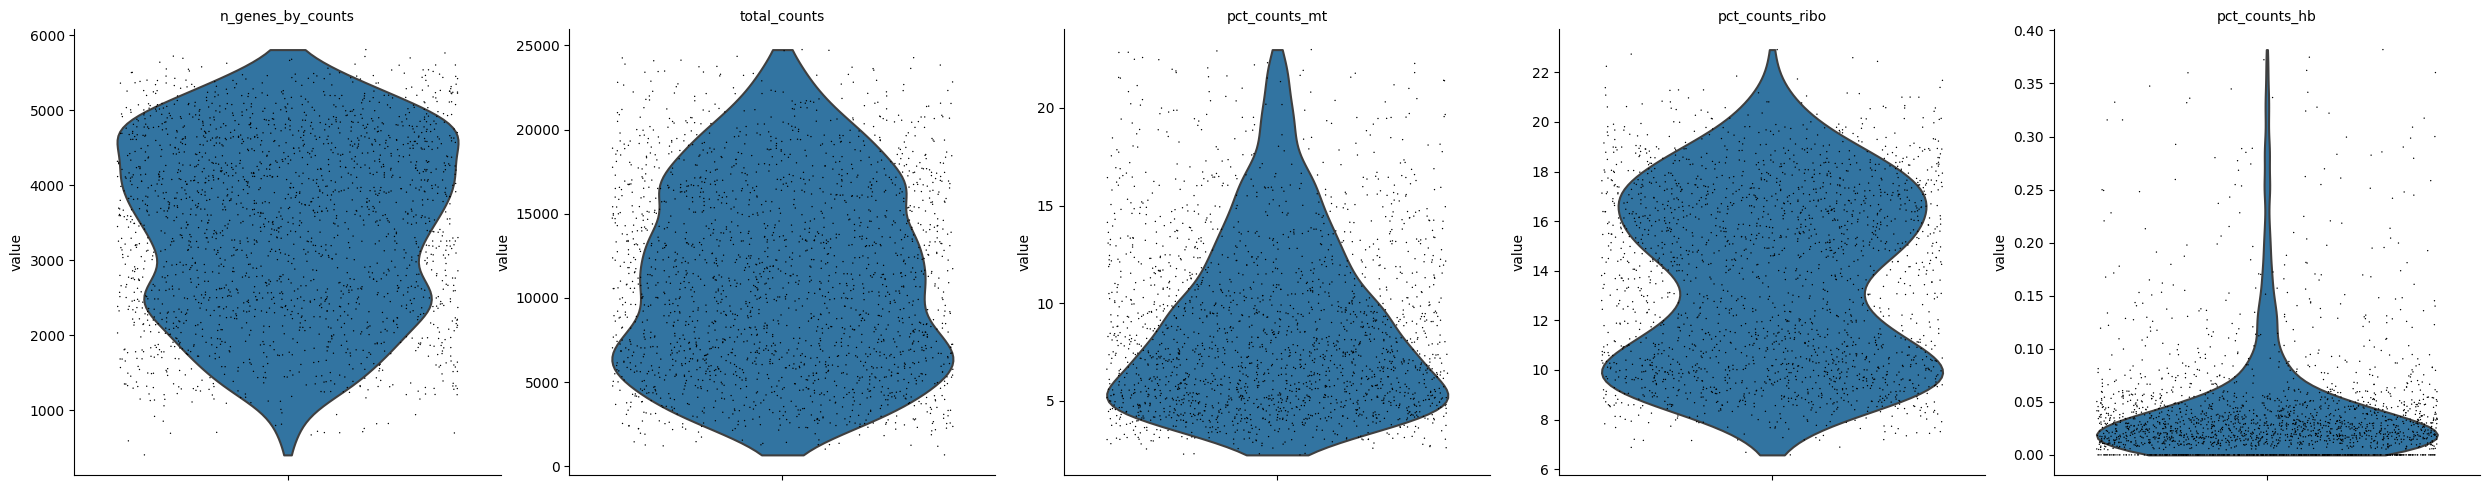

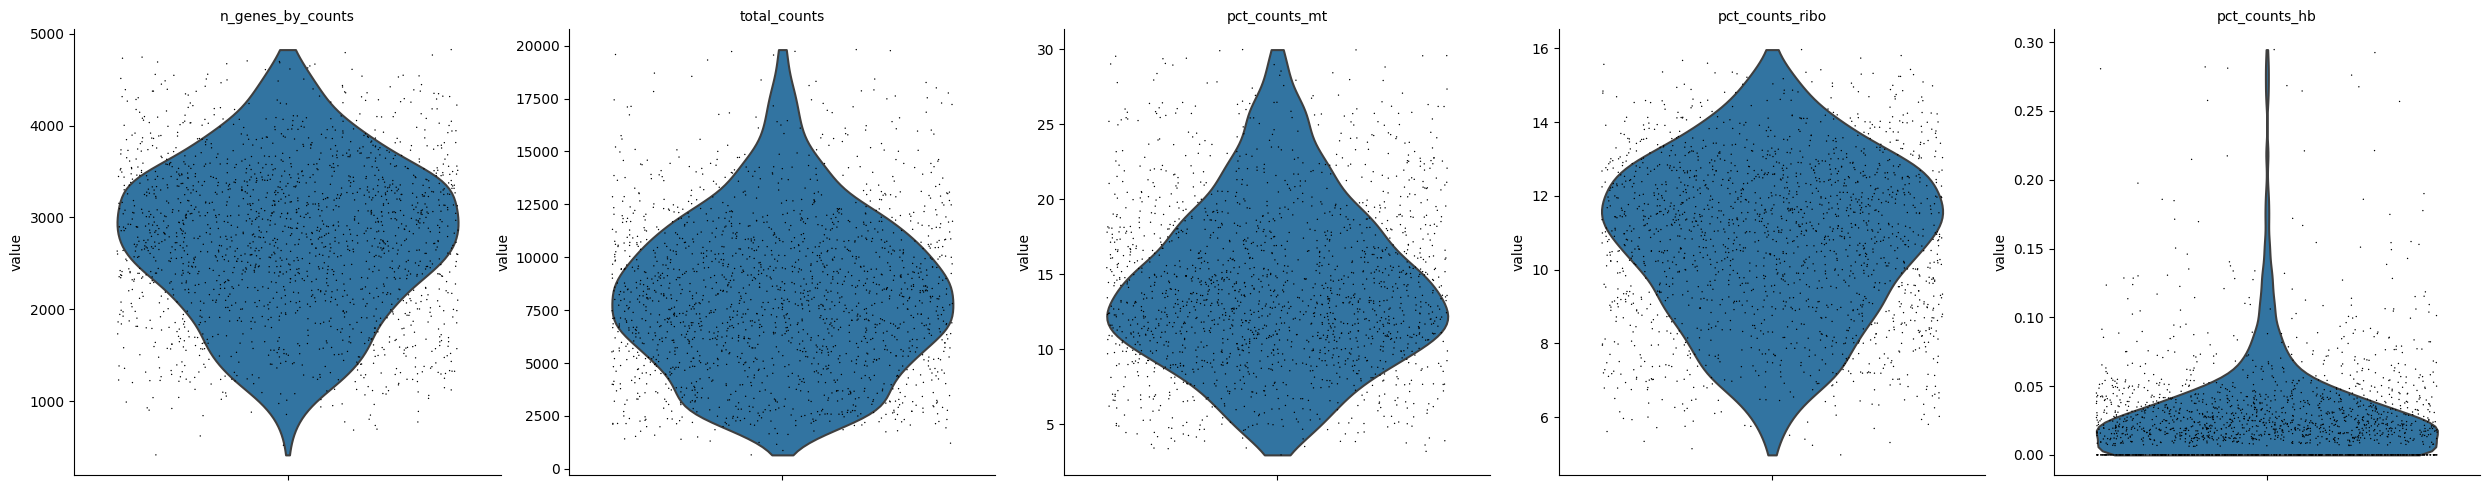

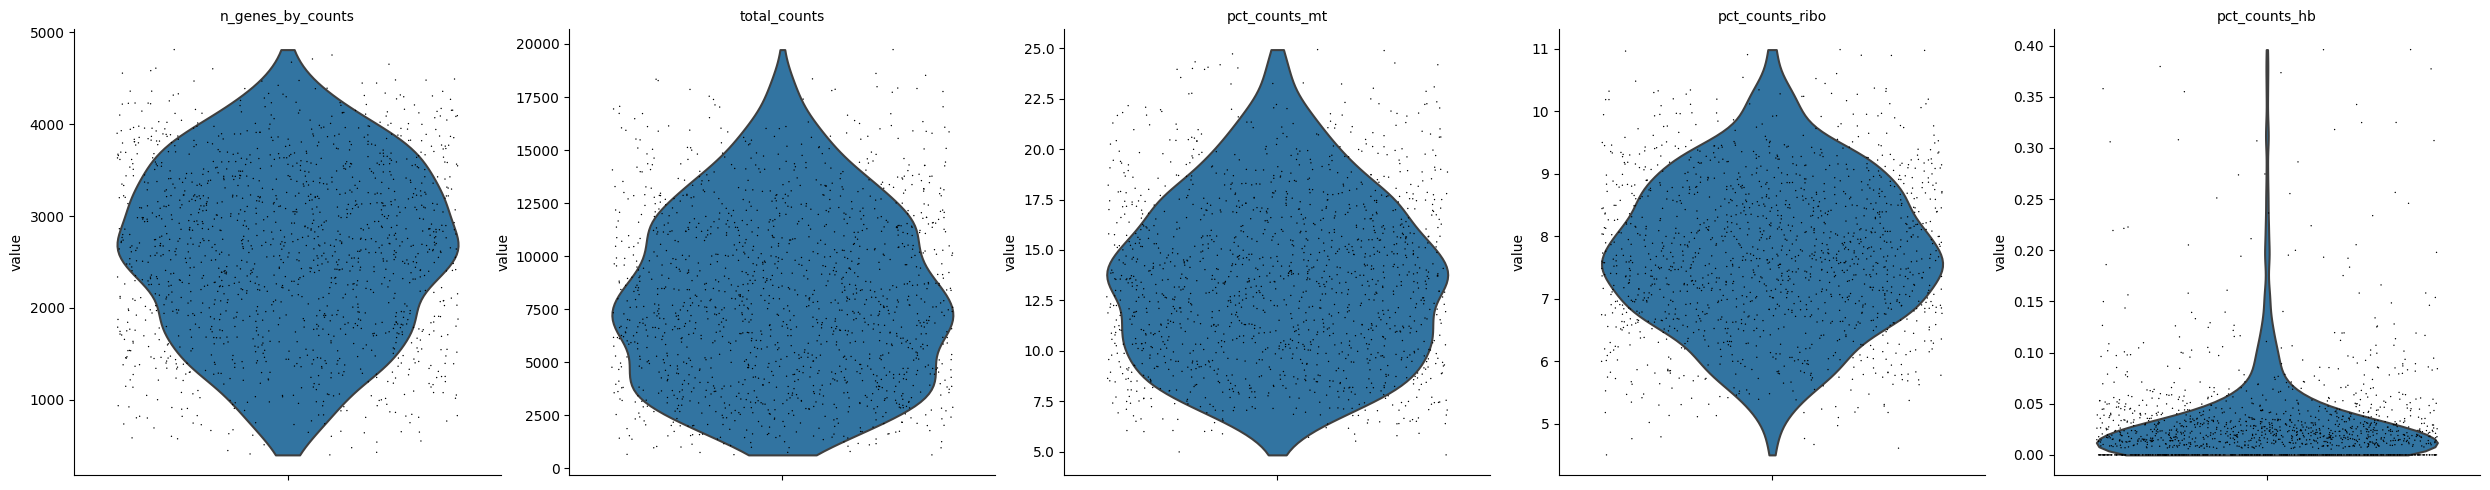

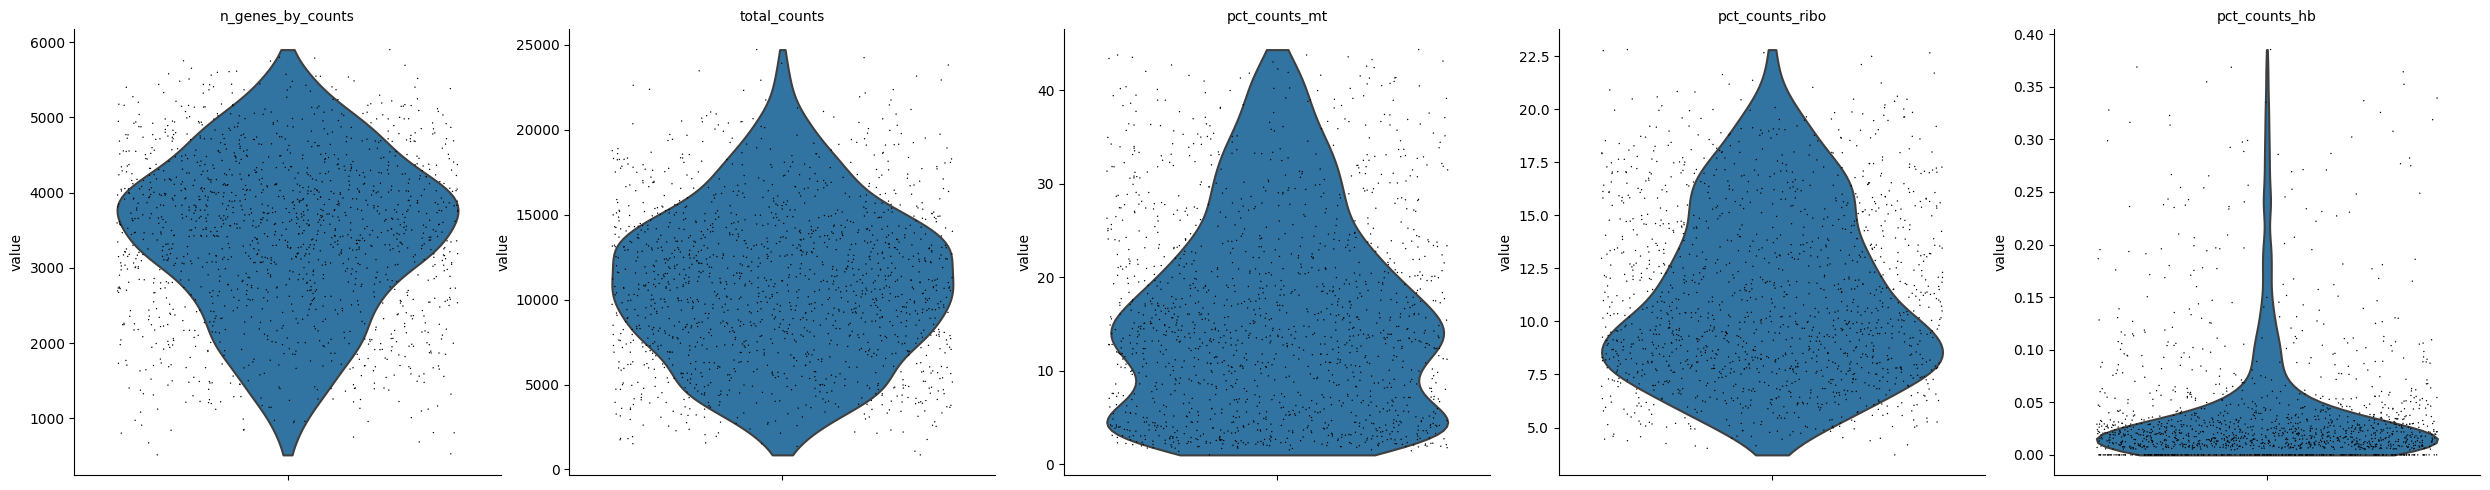

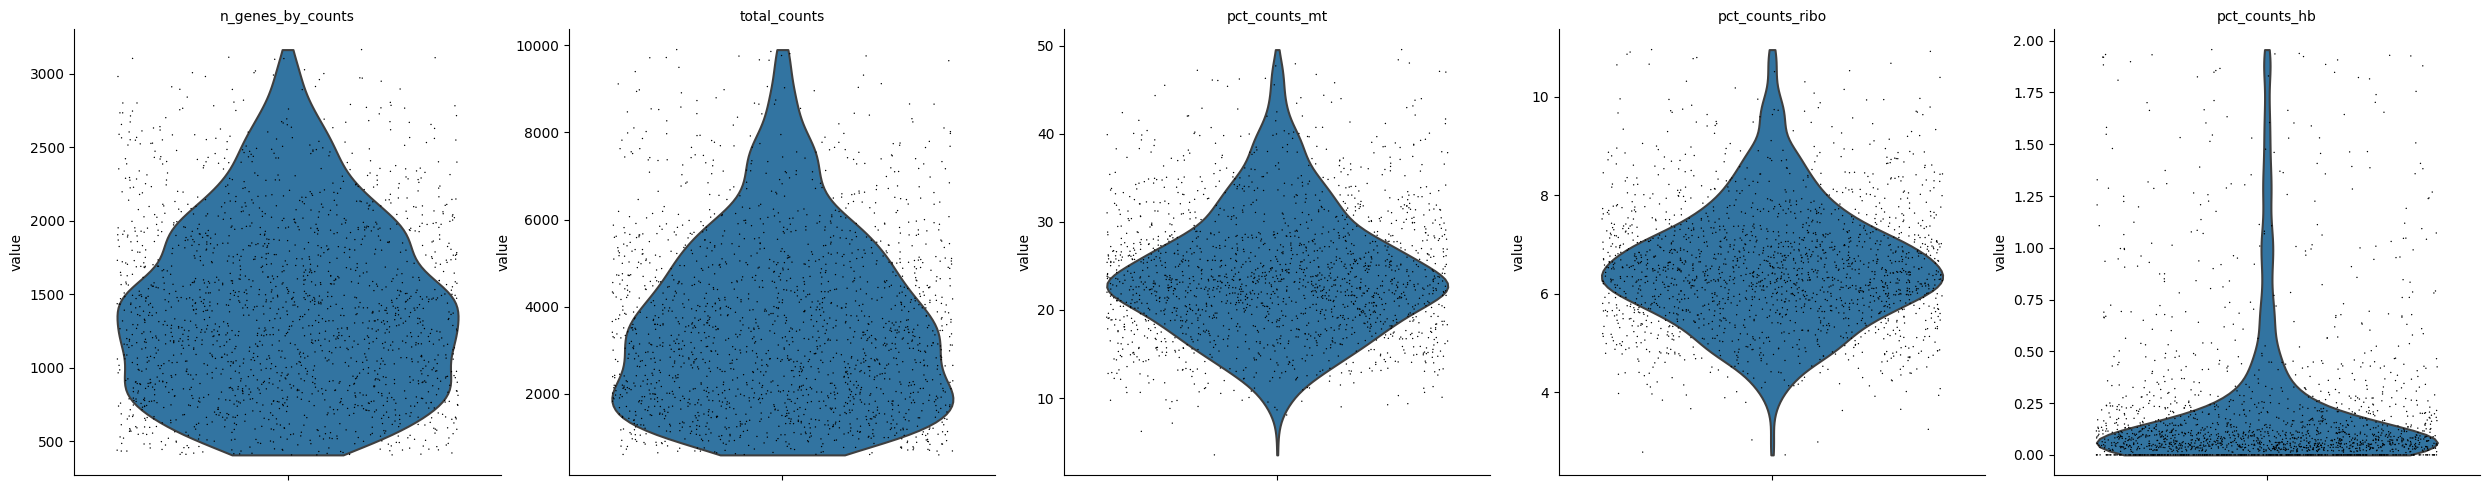

In [12]:
# Create mask
for slide in qc_thresholds.keys():
    
    adata = adatas[slide].copy()
    
    thr = qc_thresholds[slide]
    
    msk = (adata.obs['n_genes_by_counts'] < thr['gene_thr_max']) & \
        (adata.obs['n_genes_by_counts'] > thr['gene_thr_min']) & \
            (adata.obs['total_counts'] < thr['total_thr']) & \
            (adata.obs['pct_counts_mt'] < thr['mt_thr']) & \
            (adata.obs['pct_counts_ribo'] < thr['ribo_thr']) & \
            (adata.obs['pct_counts_hb'] < thr['hb_thr'])
    
    # Keep only non junk
    adatas[slide] = adata[msk, :]
    # Plot QC
    sc.pl.violin(adatas[slide], qc_metrics, jitter=0.4, rotation= 45, multi_panel=True, show=False)

## Integrate Spatial Objects

In [13]:
adata_bbknn = sc.concat(adatas, join='inner') # NOTE join='inner' is important for the assumptions that we will make later

Normalize

In [14]:
adata_bbknn.layers['counts'] = adata_bbknn.X.copy()

sc.pp.normalize_total(adata_bbknn)
sc.pp.log1p(adata_bbknn)

HVGs & PCA, NN, UMAP

In [15]:
sc.pp.highly_variable_genes(adata_bbknn, n_top_genes=2000, flavor="cell_ranger", batch_key='sample')
sc.tl.pca(adata_bbknn)
sc.pp.neighbors(adata_bbknn)
sc.tl.umap(adata_bbknn)

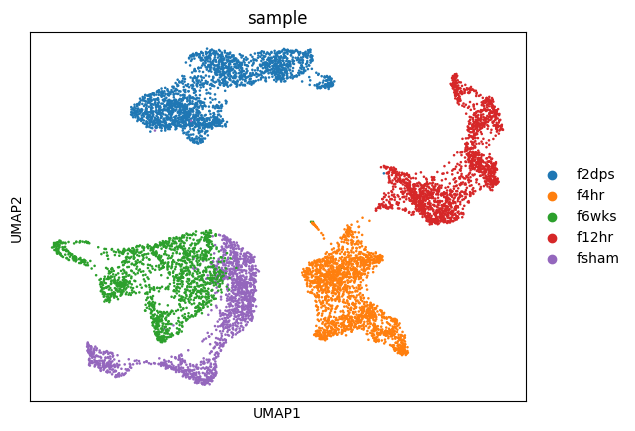

In [16]:
sc.pl.umap(adata_bbknn, color=['sample'], wspace=1)

Subset to variable genes only

In [17]:
adata_bbknn = adata_bbknn[:, adata_bbknn.var["highly_variable"]]
adata_bbknn

View of AnnData object with n_obs × n_vars = 8784 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### Integrate

In [18]:
neighbors_within_batch = 25 if adata_bbknn.n_obs > 100000 else 5

In [19]:
bbknn.bbknn(
    adata_bbknn, batch_key='sample', neighbors_within_batch=neighbors_within_batch
)
adata_bbknn


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:179: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


AnnData object with n_obs × n_vars = 8784 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

#### Cluster & Show integrated UMAP

In [20]:
sc.tl.umap(adata_bbknn)

In [21]:
sc.tl.leiden(adata_bbknn, resolution=0.3)

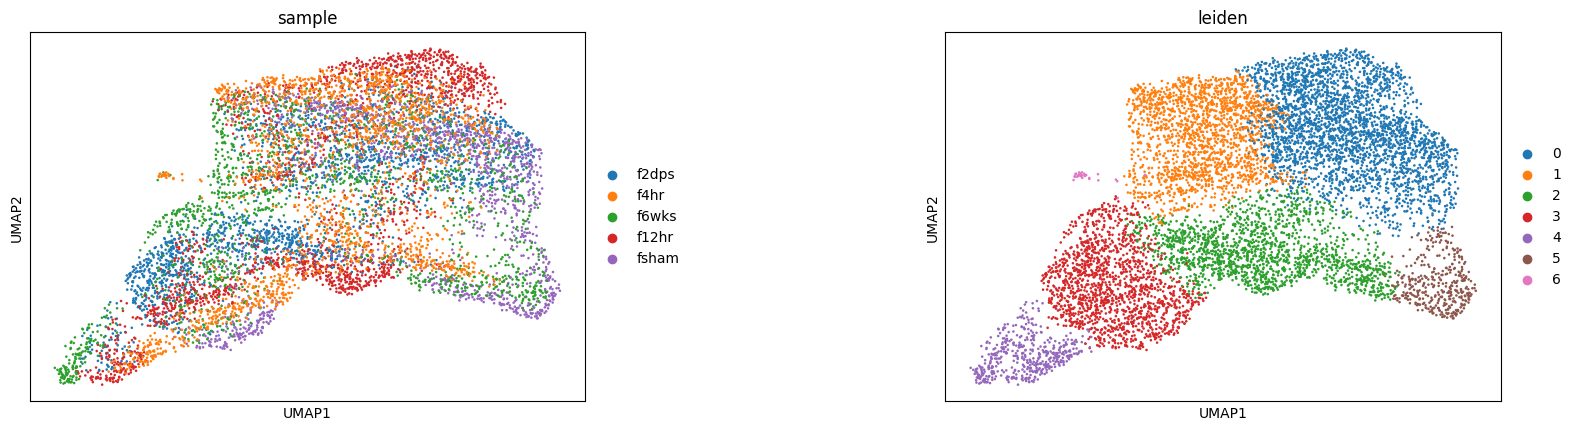

In [22]:
sc.pl.umap(adata_bbknn, color=['sample', 'leiden'], wspace=0.5)

### Check Cluster Distribution

In [23]:
cluster_distribution =  adata_bbknn.obs[['leiden', 'sample', 'array_col']].groupby(['leiden', 'sample']).count().reset_index().rename(columns={'array_col': 'count'})

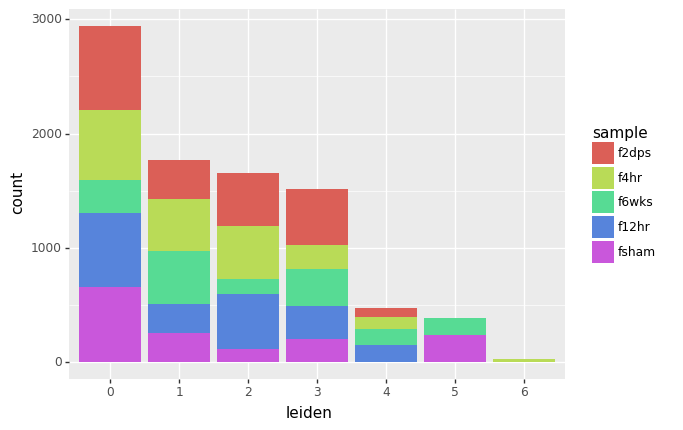

<ggplot: (8773399548430)>

In [24]:
## Plot cluster distribution
p9.ggplot(cluster_distribution) + \
    p9.aes(x='leiden', y='count', fill='sample') + \
    p9.geom_col(position='stack')

### Remove clusters with low cell numbers

In [25]:
adata_bbknn = adata_bbknn[adata_bbknn.obs['leiden']!='6']

In [26]:
adata_bbknn

View of AnnData object with n_obs × n_vars = 8753 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [27]:
adata = adatas[slide].copy()

### Show how clusters are distributed across slides

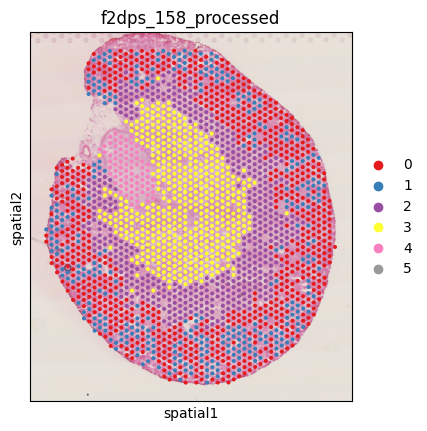

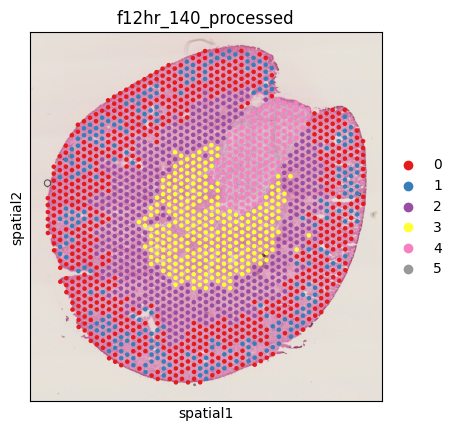

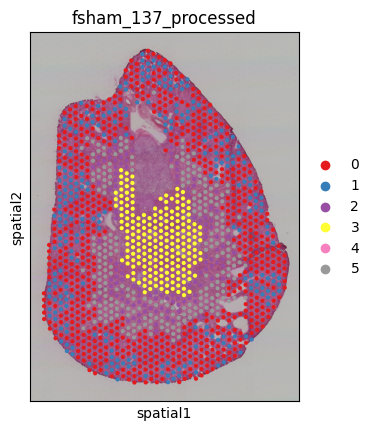

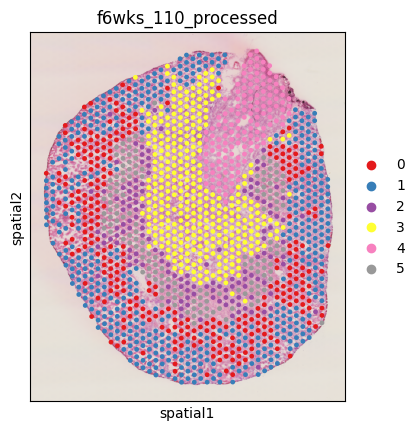

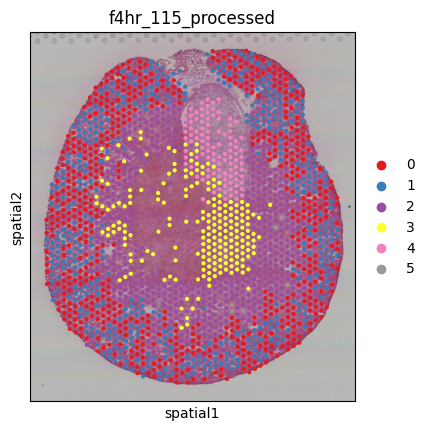

In [28]:
for slide in slides:
    adata = adatas[slide].copy()
    # keep only those cells that are in the bbknn adata
    adata = adata[adata.obs.index.isin(adata_bbknn.obs.index)]
    
    adata.obs = adata.obs.merge(adata_bbknn.obs[['leiden']], left_index=True, right_index=True)
    sc.pl.spatial(adata, color=['leiden'], palette='Set1', title=slide)

## Normalize and write

In [29]:
for slide in adatas.keys():
    ## NOTE that I copy here
    adata = adatas[slide].copy()
    
    # keep only those cells that are in the bbknn adata
    adata = adata[adata.obs.index.isin(adata_bbknn.obs.index)]
    
    # add the leiden clusters
    adata.obs = adata.obs.merge(adata_bbknn.obs[['leiden']], left_index=True, right_index=True)
    
    # Normalize only copies
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # save them
    adata.write_h5ad('/home/dbdimitrov/Repos/liana2_manuscript/data/kidney_injury/visium/' + slide + '.h5ad')

## Run LIANA

In [ ]:
import liana as li
from liana.method.sp import lr_basis, basis

In [ ]:
adata = adatas['f2dps_158_processed'].copy()

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
sq.gr.spatial_neighbors(adata, n_rings=2, coord_type="grid", n_neighs=6)

In [ ]:
adata.obsp["spatial_connectivities"]

In [ ]:
lr_basis(adata,
         function_name="jaccard",
         expr_prop=0.1,
         resource_name="MouseConsensus", 
         pvalue_method=None, 
         use_raw=False, 
         positive_only=True,
         proximity_key="spatial_connectivities",
         )

In [ ]:
adata.uns['global_res'].sort_values('global_mean').tail(10)

In [ ]:
# save results as modalities
local_lr  = li.fun.obsm_to_adata(adata, 'local_scores')
# local_pvals = li.fun.obsm_to_adata(adata, 'local_pvals')

In [ ]:
sc.pl.spatial(local_lr, color=['Sparc&Eng', 'Thbs1&Itga3_Itgb1'], cmap='coolwarm')

In [ ]:
sc.pl.spatial(adata, color=['Thbs1', 'Itga3', 'Itgb1'], cmap='cividis')